# EDA of Dataset

Setting a random seed to ensure consistent EDA, will include in other code chunks specifically too

In [3]:
import random
import numpy as np

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

## View of dataset images
**Why are we getting a view of the dataset images?**

To understand what sort of images there are in the training and the test datasets as a preliminary view to help users visualize what images there are in the classes.

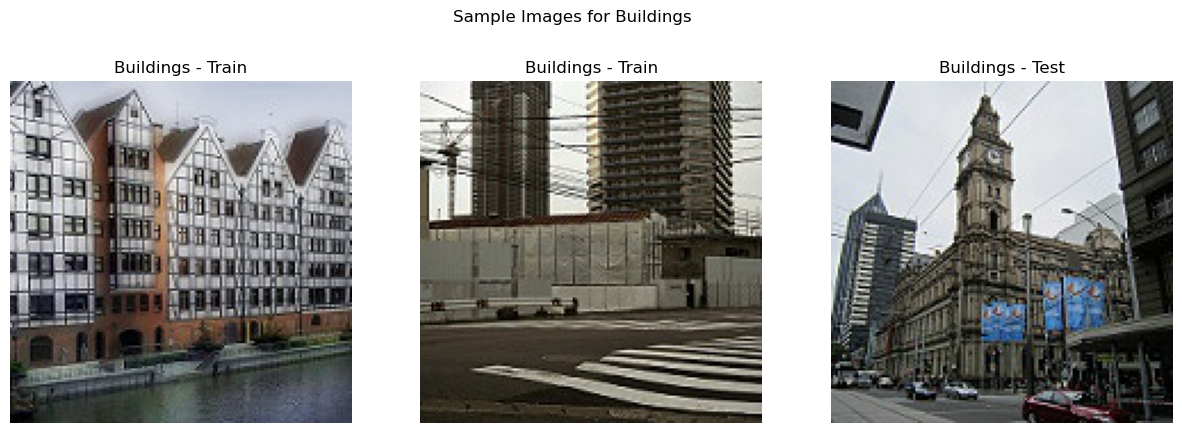

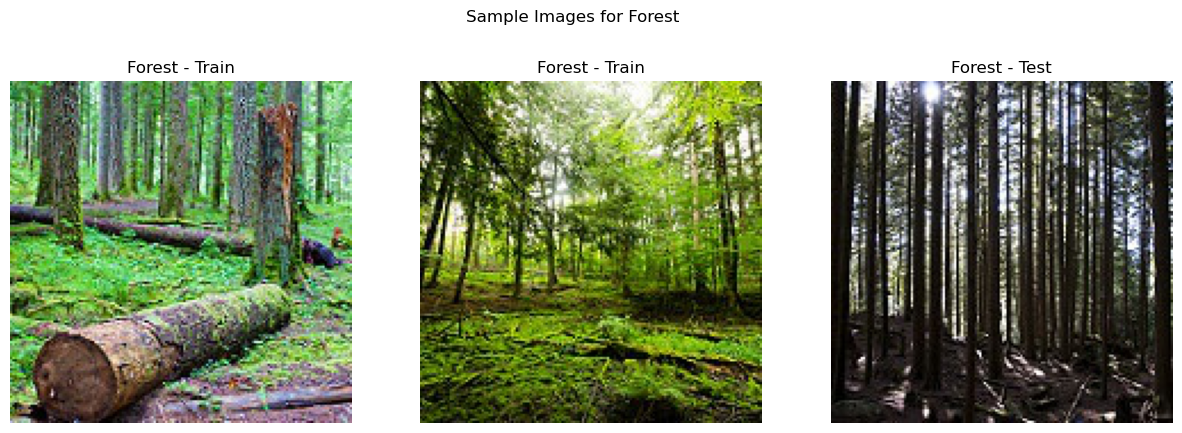

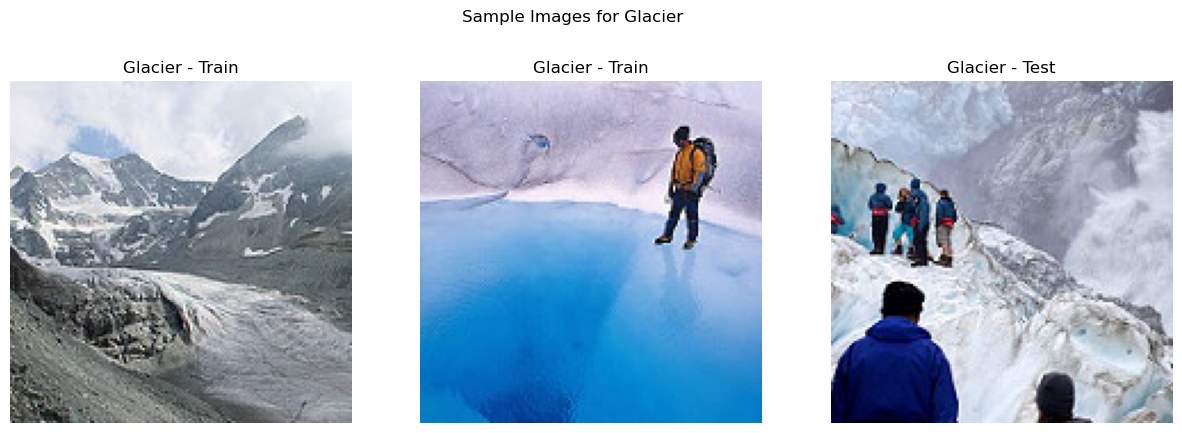

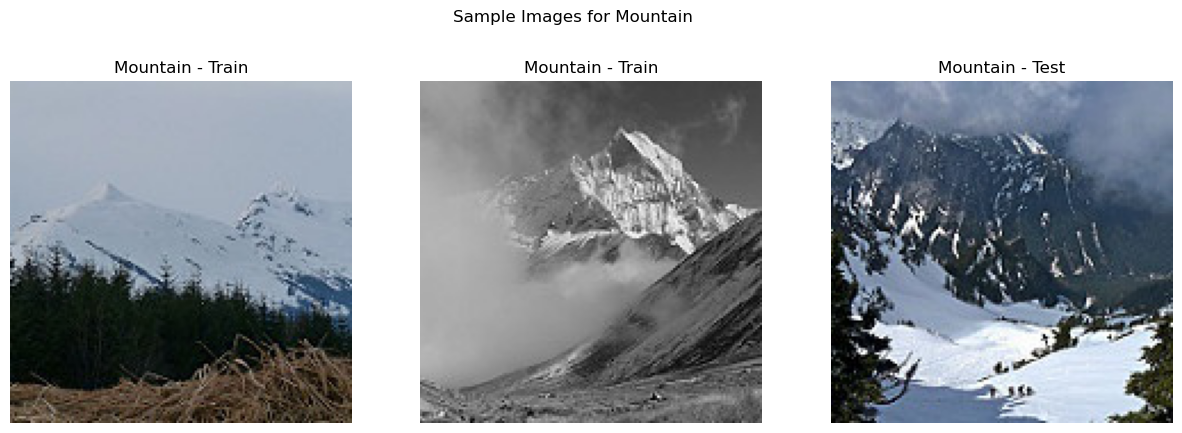

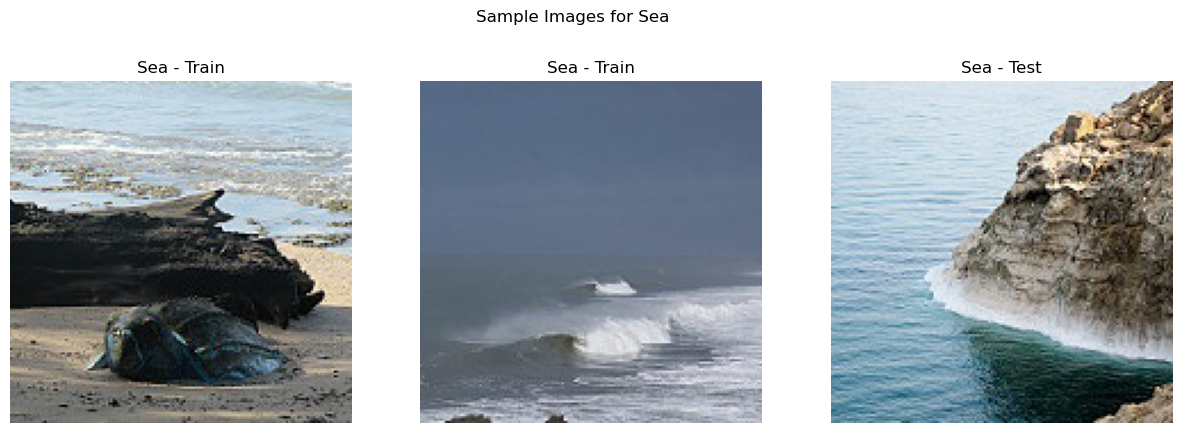

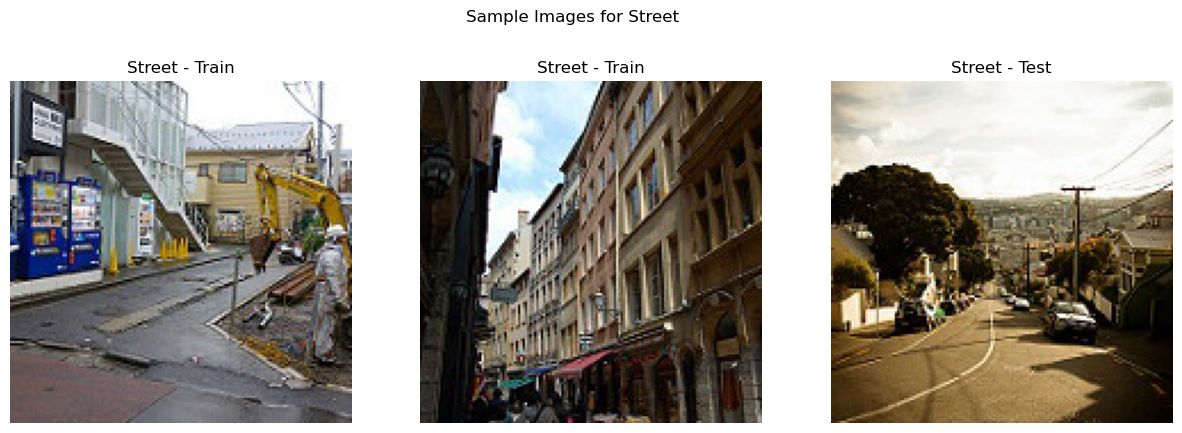

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

def display_images_for_class(class_name, num_train, num_test, new_train_dir, new_test_dir):
    # Paths for the specific class in the new training and test directories
    new_train_class_dir = os.path.join(new_train_dir, class_name)
    new_test_class_dir = os.path.join(new_test_dir, class_name)
    
    # Sort the image lists to ensure a consistent order
    train_images = sorted(os.listdir(new_train_class_dir))
    test_images = sorted(os.listdir(new_test_class_dir))
    
    # Randomly sample images using the sorted lists
    train_samples = random.sample(train_images, min(num_train, len(train_images)))
    test_samples = random.sample(test_images, min(num_test, len(test_images)))
    
    # Combine samples and create labels
    total_images = train_samples + test_samples
    labels = ['Train'] * len(train_samples) + ['Test'] * len(test_samples)
    
    plt.figure(figsize=(15, 5))
    for i, (img_name, label) in enumerate(zip(total_images, labels)):
        if label == 'Train':
            img_path = os.path.join(new_train_class_dir, img_name)
        else:
            img_path = os.path.join(new_test_class_dir, img_name)
        img = image.load_img(img_path, target_size=(150, 150))
        plt.subplot(1, len(total_images), i + 1)
        plt.imshow(img)
        plt.title(f"{class_name.capitalize()} - {label}")
        plt.axis('off')
    plt.suptitle(f"Sample Images for {class_name.capitalize()}")
    plt.show()

# Define new paths for training and test sets using the copied dataset folder
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')

# Visualize examples for each class from the copied dataset using the new variable names
display_images_for_class('buildings', num_train=2, num_test=1, new_train_dir=new_train_dir, new_test_dir=new_test_dir)
display_images_for_class('forest', num_train=2, num_test=1, new_train_dir=new_train_dir, new_test_dir=new_test_dir)
display_images_for_class('glacier', num_train=2, num_test=1, new_train_dir=new_train_dir, new_test_dir=new_test_dir)
display_images_for_class('mountain', num_train=2, num_test=1, new_train_dir=new_train_dir, new_test_dir=new_test_dir)
display_images_for_class('sea', num_train=2, num_test=1, new_train_dir=new_train_dir, new_test_dir=new_test_dir)
display_images_for_class('street', num_train=2, num_test=1, new_train_dir=new_train_dir, new_test_dir=new_test_dir)

## Count of dataset images by class
**Why are we getting a count of images in each of the classes in the test and the training datasets?**

We want to explore the variance in the classes of images provided in the datasest. If there is a huge variance, the trained model may be biased on one class. We can check and adjust the parameters based on our findings after the first iterations of the model.

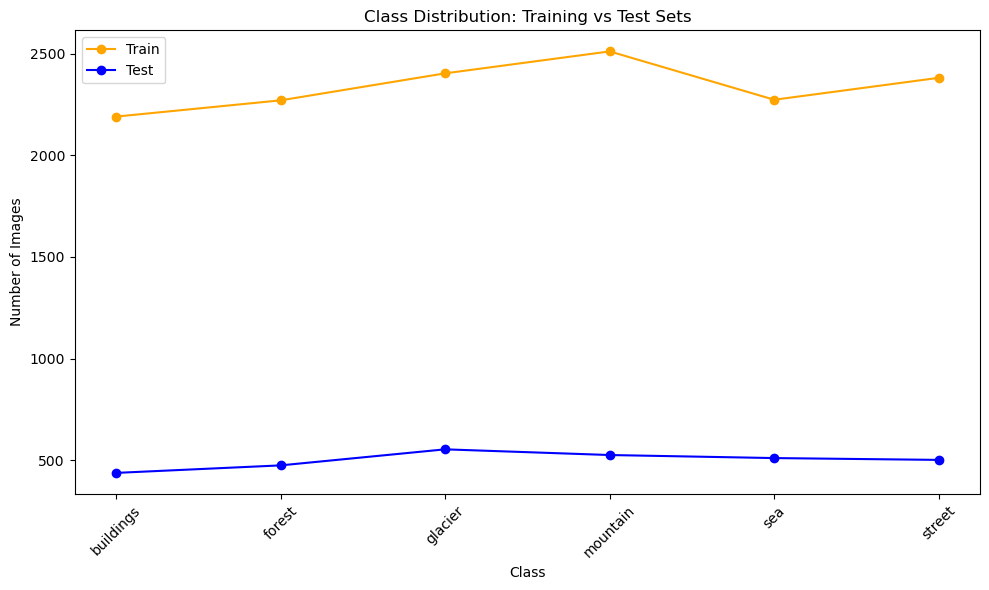

 Both the train and the test datasets have some variances in the count of images from each class. We can try standardizing the
number of images from each class for one of the iterations and check whether we get a better output evaluation.


In [7]:
import os
import matplotlib.pyplot as plt
import textwrap

# Define directories for training and test sets from the copied dataset
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')

def count_images(directory):
    counts = {}
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        counts[cls] = len(images)
    return counts

# Get counts for training and test sets from the copied dataset
train_counts = count_images(new_train_dir)
test_counts = count_images(new_test_dir)

# Ensure same class order for both sets
classes = sorted(set(list(train_counts.keys()) + list(test_counts.keys())))
train_values = [train_counts.get(cls, 0) for cls in classes]
test_values = [test_counts.get(cls, 0) for cls in classes]

plt.figure(figsize=(10, 6))
plt.plot(classes, train_values, marker='o', color='orange', label='Train')
plt.plot(classes, test_values, marker='o', color='blue', label='Test')
plt.title('Class Distribution: Training vs Test Sets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

long_text = (
    "\nBoth the train and the test datasets have some variances in the count of images from each class. "
    "We can try standardizing the number of images from each class for one of the iterations and check whether "
    "we get a better output evaluation."
)

wrapped_text = textwrap.fill(long_text, width=130)
print(wrapped_text)

## Pixel distribution by class
**Why are we doing pixel distribution on the classes in the data?**

Examining the pixel intensity distributions of sample images (for each RGB channel) helps me verify the quality and consistency of the images. It reveals if images are overexposed, underexposed, or have unusual color distributions that might affect how my model learns features.

Pixel intensity distribution for class: forest


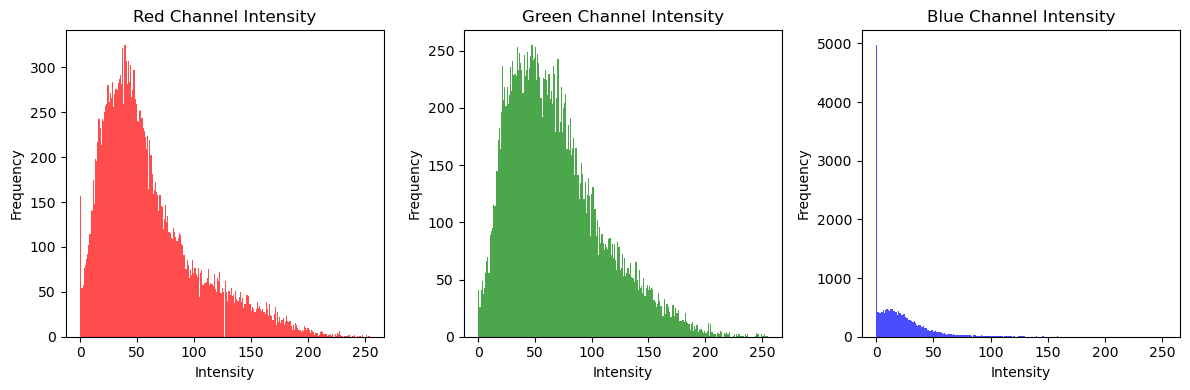

Pixel intensity distribution for class: buildings


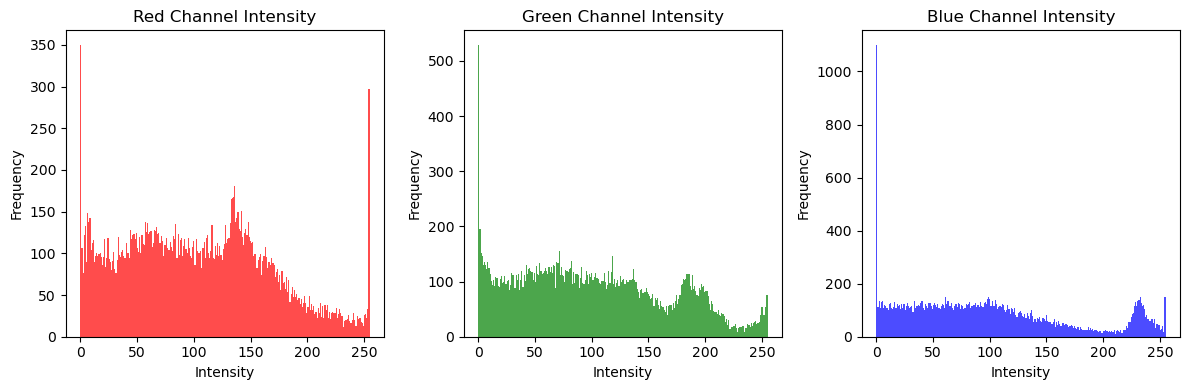

Pixel intensity distribution for class: glacier


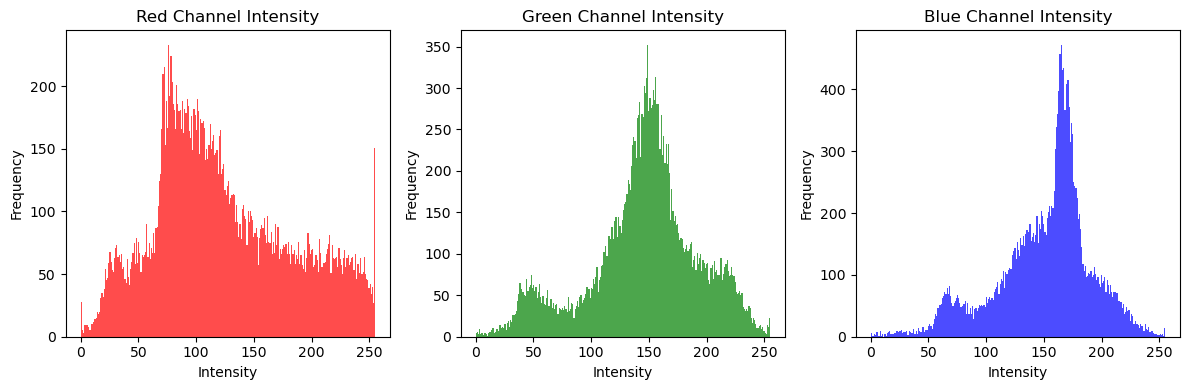

Pixel intensity distribution for class: street


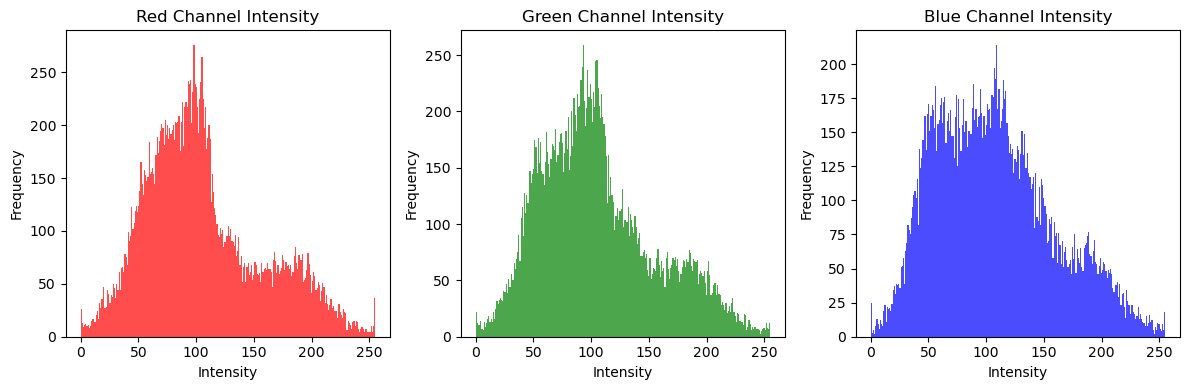

Pixel intensity distribution for class: mountain


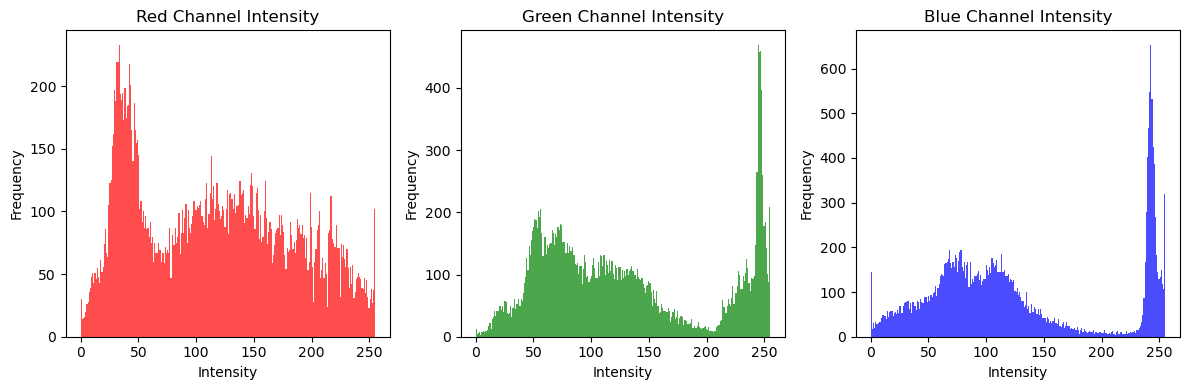

Pixel intensity distribution for class: sea


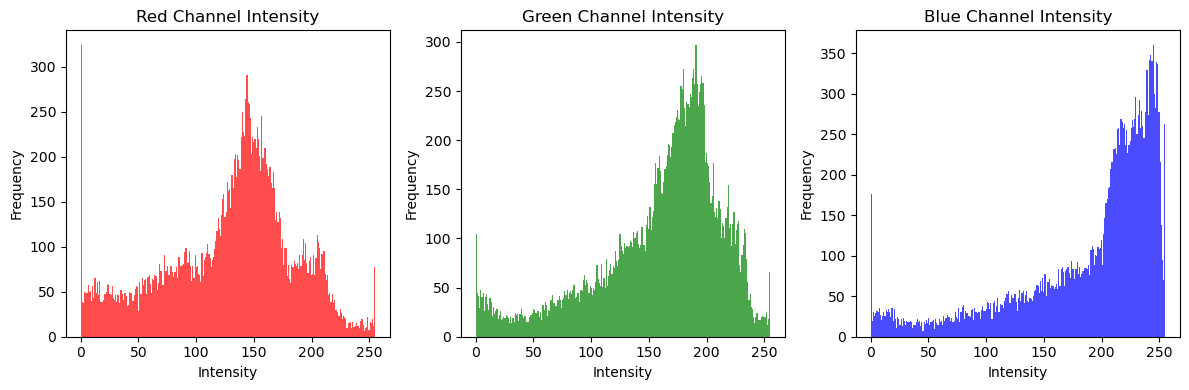


In this EDA, a sharp peak on the lower end may suggest underexposure.
A sharp peak on the higher end may suggest overexposure.
If one channel differs significantly from the others, it might suggest color cast issues.
For a well-balanced image, each channel might show a roughly bell-shaped curve.

 From the EDA, we can see that there are some classes which have over or underexposure based on the selected images for this EDA.
Due to this, we could remove problematic images from our analysis during an iteration and check if there is any improvement in the
accuracy.


In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from PIL import Image  # Importing the Image class from Pillow

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

def plot_pixel_intensity_distribution(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_np = np.array(img)
        red = img_np[:, :, 0].flatten()
        green = img_np[:, :, 1].flatten()
        blue = img_np[:, :, 2].flatten()
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.hist(red, bins=256, color='red', alpha=0.7)
        plt.title('Red Channel Intensity')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 3, 2)
        plt.hist(green, bins=256, color='green', alpha=0.7)
        plt.title('Green Channel Intensity')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 3, 3)
        plt.hist(blue, bins=256, color='blue', alpha=0.7)
        plt.title('Blue Channel Intensity')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Define new training directory from the copied dataset
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')

# For each class, plot the pixel intensity distribution using one sample image from the new training set
for cls in os.listdir(new_train_dir):
    new_train_class_dir = os.path.join(new_train_dir, cls)
    images = [f for f in os.listdir(new_train_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        sample_image_path = os.path.join(new_train_class_dir, random.choice(images))
        print(f"Pixel intensity distribution for class: {cls}")
        plot_pixel_intensity_distribution(sample_image_path)

long_text = (
    "\nFrom the EDA, we can see that there are some classes which have over or underexposure based on the "
    "selected images for this EDA. Due to this, we could remove problematic images from our analysis during an iteration "
    "and check if there is any improvement in the accuracy."
)

wrapped_text = textwrap.fill(long_text, width=130)

print("\nIn this EDA, a sharp peak on the lower end may suggest underexposure."
      "\nA sharp peak on the higher end may suggest overexposure."
      "\nIf one channel differs significantly from the others, it might suggest color cast issues."
      "\nFor a well-balanced image, each channel might show a roughly bell-shaped curve.\n")
print(wrapped_text)

## File sizes by class
**Why are we checking the file sizes of the classes in the data?**

The file sizes of the images can vary for each class based on a number of different factors, including color scheme, resolution or file type. We want to just have a check on the file sizes to ensure there are no huge outlying files which need to be removed from the analysis to maintain some standardization in images and maintain fairness amongst the dataset for model training.

In [11]:
# Define consistent color mapping for classes
color_mapping = {
    'buildings': 'grey',
    'sea': 'blue',
    'forest': 'green',
    'mountain': 'brown',
    'street': 'red',
    'glacier': 'purple'
}

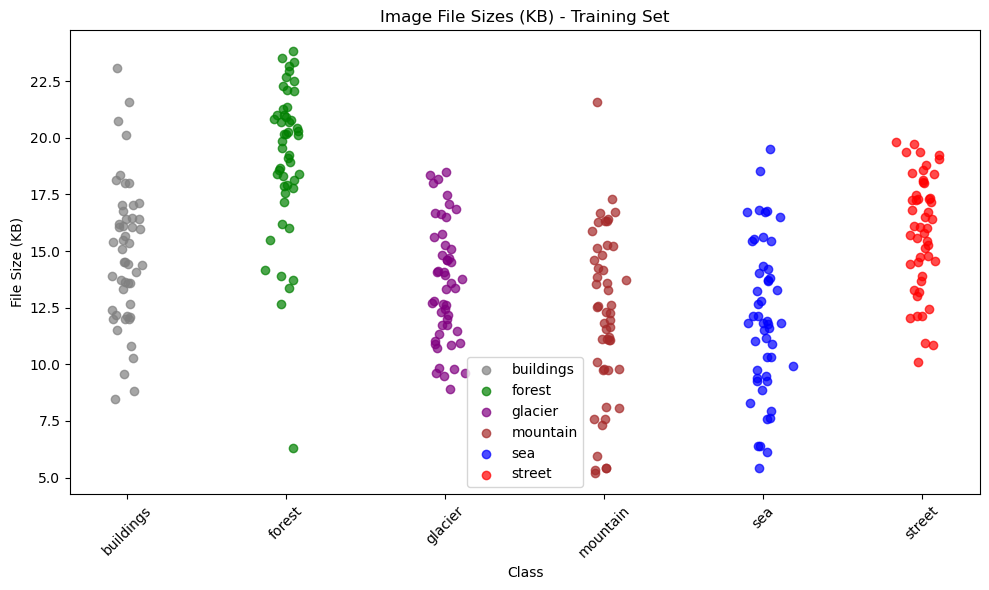

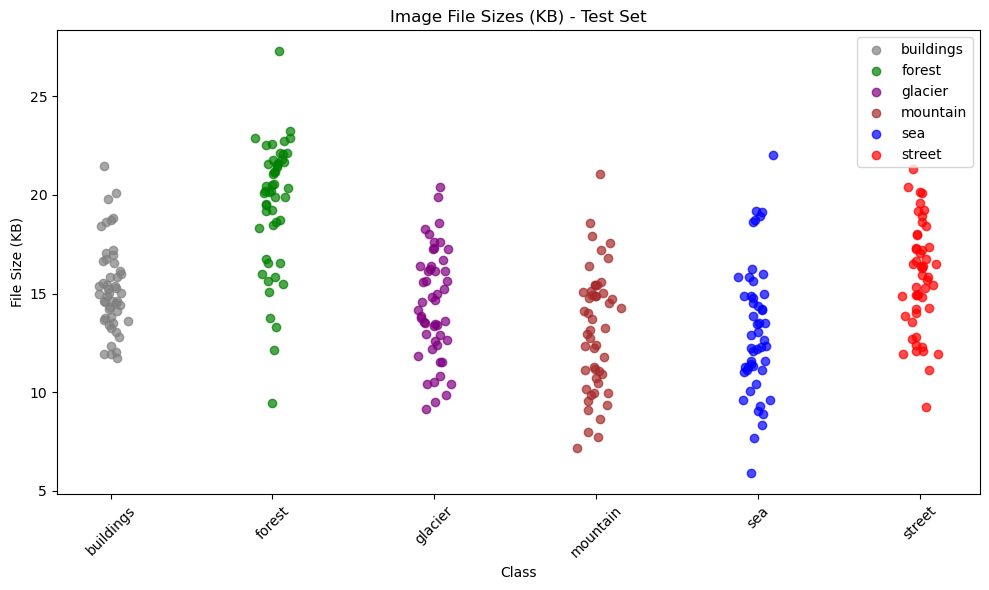

 From the EDA, the dataset is slightly varied in size by class, with forest images leading in both training and test sets;
however, these variations are not significant enough to be considered outliers.


In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import statistics

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Define consistent color mapping for classes
color_mapping = {
    'buildings': 'grey',
    'sea': 'blue',
    'forest': 'green',
    'mountain': 'brown',
    'street': 'red',
    'glacier': 'purple'
}

# Function to compute raw file sizes for each class in a directory
def file_size_raw(directory, sample_limit=50):
    raw = {}
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        # Get a sorted list of image files for consistency
        images = sorted([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        sampled_images = images[:min(sample_limit, len(images))]
        sizes = []
        for img_name in sampled_images:
            img_path = os.path.join(cls_path, img_name)
            try:
                size_kb = os.path.getsize(img_path) / 1024  # Convert bytes to kilobytes
                sizes.append(size_kb)
            except Exception as e:
                print(f"Error getting size for {img_path}: {e}")
        raw[cls] = sizes
    return raw

# Define new directories for the copied dataset
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
new_test_dir  = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')

# Compute raw file sizes for the new training and test sets
new_train_file_raw = file_size_raw(new_train_dir)
new_test_file_raw = file_size_raw(new_test_dir)

# Scatter plot function for file sizes using raw data
def scatter_file_sizes(file_sizes, title):
    plt.figure(figsize=(10, 6))
    # Sort classes for consistent ordering
    classes = sorted(file_sizes.keys())
    for i, cls in enumerate(classes):
        sizes = file_sizes[cls]
        # Create x-values with jitter to separate the points on the x-axis
        x_values = np.random.normal(i, 0.05, len(sizes))
        # Use the color mapping; convert class name to lowercase for consistency
        color = color_mapping.get(cls.lower(), 'black')
        plt.scatter(x_values, sizes, label=cls, color=color, alpha=0.7)
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('File Size (KB)')
    plt.title(title)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Plot scatter plots using the raw file sizes
scatter_file_sizes(new_train_file_raw, "Image File Sizes (KB) - Training Set")
scatter_file_sizes(new_test_file_raw, "Image File Sizes (KB) - Test Set")

wrapped_text = textwrap.fill(
    "\nFrom the EDA, the dataset is slightly varied in size by class, with forest images leading in both training and test sets; however, these variations are not significant enough to be considered outliers.",
    width=130
)
print(wrapped_text)

## Checking if images have metadata
**Why are we checking if images in the classes have metadata?**

Checking for metadata is valuable because it provides additional context about how and when an image was captured.
Metadata can include camera settings (such as exposure time, aperture, ISO) which help us understand the lighting and environmental conditions under which an image was taken. This information can be useful for detecting inconsistencies or anomalies in the dataset.
Images with unusual metadata (e.g., extremely high ISO or unusual exposure settings) might be indicative of low-quality images or those captured under suboptimal conditions. Detecting these can inform decisions on whether to exclude certain images or apply specific preprocessing.

In [15]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

def check_sample_metadata(directory, sample_limit=100):
    found_metadata = False
    # Loop over all classes in the directory
    for cls in sorted(os.listdir(directory)):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            # Get a sorted list of image files for consistency
            images = sorted([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            # Sample up to 'sample_limit' images randomly
            if len(images) > sample_limit:
                sampled_images = random.sample(images, sample_limit)
            else:
                sampled_images = images
            for filename in sampled_images:
                img_path = os.path.join(cls_path, filename)
                try:
                    with Image.open(img_path) as img:
                        exif_data = img._getexif()
                    if exif_data:
                        found_metadata = True
                        # Convert exif_data to a human-readable dictionary
                        exif = {ExifTags.TAGS.get(tag, tag): value for tag, value in exif_data.items()}
                        print(f"\nEXIF data for {img_path}:")
                        for key, value in exif.items():
                            print(f"  {key}: {value}")
                        # Display the image
                        plt.figure(figsize=(6, 6))
                        plt.imshow(img)
                        plt.title(f"Image: {cls} - {filename}")
                        plt.axis('off')
                        plt.show()
                except Exception as e:
                    print(f"Error reading EXIF data from {img_path}: {e}")
    if not found_metadata:
        print("There is no metadata found in any of the sampled images.")

# Define the new training directory from the copied dataset
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')

# Scan through up to 100 images per class for metadata in the new training set
check_sample_metadata(new_train_dir, sample_limit=100)

There is no metadata found in any of the sampled images.


## Checking for brightness distribution of classes
**Why are we checking the brightness distribution of the classes in the data?**

Variations in brightness across images can indicate inconsistencies in how the images were captured. For example, some images might be overexposed or underexposed, which can affect the model’s ability to learn consistent features. If I notice that certain classes consistently have darker or lighter images, I might need to apply additional preprocessing steps—such as brightness normalization or contrast adjustments—to ensure the model sees a uniform range of intensities.

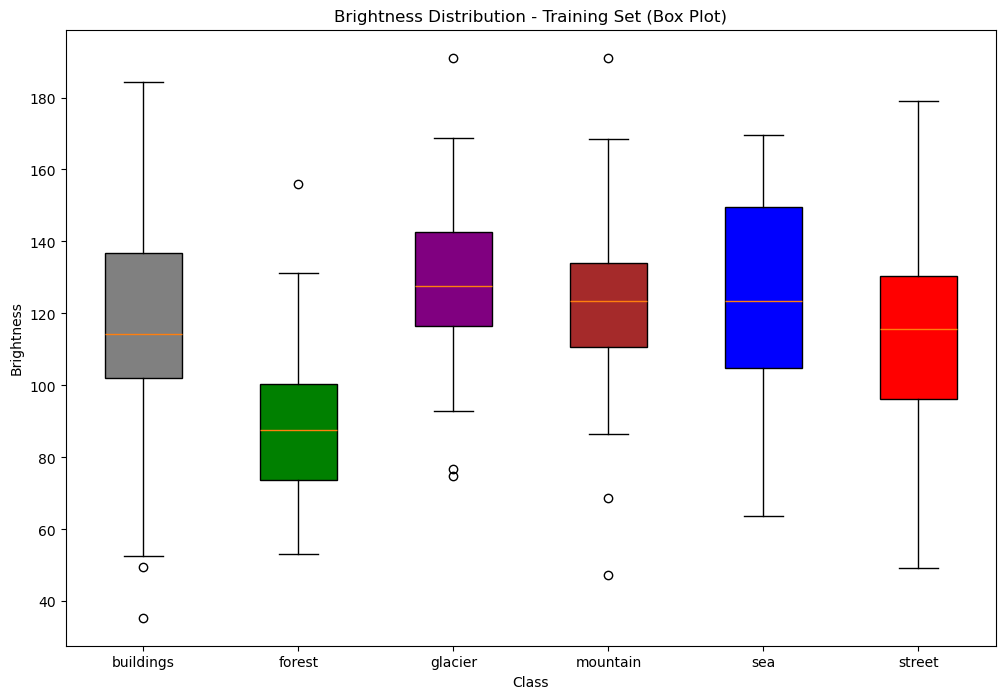

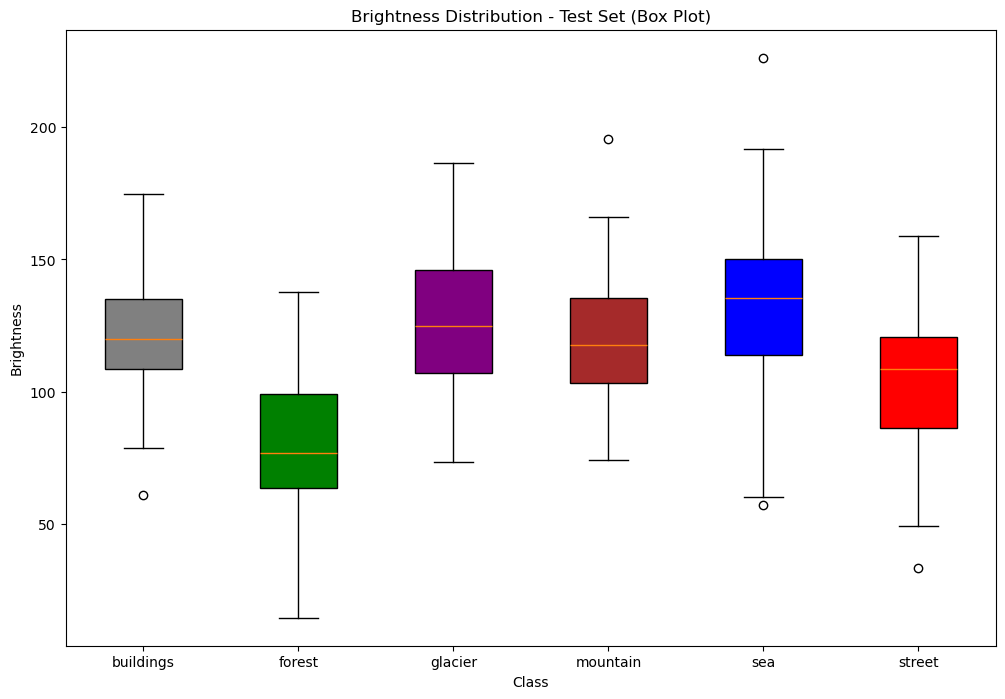

 From the EDA, we see that forest images are normally of a lower brightness distribution in both the training and the test
datasets, presumably due to dark spots caused by tree shadows. Interestingly, the building and street images cover a wide range of
brightness distribution in the training set, while the test set shows a narrower range. It is vice versa for the sea images.


In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Define consistent color mapping for classes
color_mapping = {
    'buildings': 'grey',
    'sea': 'blue',
    'forest': 'green',
    'mountain': 'brown',
    'street': 'red',
    'glacier': 'purple'
}

# Function to compute average brightness of an image
def compute_brightness(image_path):
    try:
        with Image.open(image_path) as img:
            gray = img.convert('L')
            brightness = np.array(gray).mean()
        return brightness
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to gather brightness data for each class in a directory
def gather_brightness(directory, sample_limit=50):
    brightness_data = {}
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        # Use random.sample on a sorted list for consistency
        sampled_images = random.sample(sorted(images), min(sample_limit, len(images)))
        brightness_values = []
        for img_name in sampled_images:
            img_path = os.path.join(cls_path, img_name)
            brightness = compute_brightness(img_path)
            if brightness is not None:
                brightness_values.append(brightness)
        brightness_data[cls] = brightness_values
    return brightness_data

# Define paths for the copied training and test sets
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')

# Gather brightness data from the copied dataset
train_brightness = gather_brightness(new_train_dir)
test_brightness = gather_brightness(new_test_dir)

# Box Plot for Training Set Brightness
plt.figure(figsize=(12, 8))
classes_sorted = sorted(train_brightness.keys())
data = [train_brightness[cls] for cls in classes_sorted]
bp = plt.boxplot(data, patch_artist=True, labels=classes_sorted)
for patch, cls in zip(bp['boxes'], classes_sorted):
    patch.set_facecolor(color_mapping.get(cls.lower(), 'black'))
plt.title('Brightness Distribution - Training Set (Box Plot)')
plt.xlabel('Class')
plt.ylabel('Brightness')
plt.show()

# Box Plot for Test Set Brightness
plt.figure(figsize=(12, 8))
classes_sorted = sorted(test_brightness.keys())
data = [test_brightness[cls] for cls in classes_sorted]
bp = plt.boxplot(data, patch_artist=True, labels=classes_sorted)
for patch, cls in zip(bp['boxes'], classes_sorted):
    patch.set_facecolor(color_mapping.get(cls.lower(), 'black'))
plt.title('Brightness Distribution - Test Set (Box Plot)')
plt.xlabel('Class')
plt.ylabel('Brightness')
plt.show()

wrapped_text = textwrap.fill(
    "\nFrom the EDA, we see that forest images are normally of a lower brightness distribution in both the training and the test datasets, presumably due to dark spots caused by tree shadows. Interestingly, the building and street images cover a wide range of brightness distribution in the training set, while the test set shows a narrower range. It is vice versa for the sea images.",
    width=130
)
print(wrapped_text)